In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import seaborn as sns

from statannot import add_stat_annotation
from sklearn import metrics


import scipy.stats as stats

from grs_pca import perform_grs_pca

/slade/home/pl450/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from survival_analysis.grsplot import format_p_value

In [3]:
from survival_analysis.utilities_mod import * 
from survival_analysis.stratifiedKM_plot import * 
import survival_analysis.backward_elimination
import survival_analysis.model_fitter 

#
import survival_analysis.grsplot as grsplot
import importlib


In [4]:
import warnings
from lifelines.utils import ConvergenceWarning

# Suppress ConvergenceWarnings globally
warnings.filterwarnings('ignore', category=ConvergenceWarning, module='lifelines.*')

# Suppress specific FutureWarnings from lifelines package
warnings.filterwarnings('ignore', category=FutureWarning, module='lifelines.utils')
warnings.filterwarnings('ignore', category=FutureWarning, module='lifelines.utils.printer')


In [5]:
import pickle
from datetime import datetime

In [6]:
# Reload the module
importlib.reload(grsplot)

<module 'survival_analysis.grsplot' from '/slade/home/pl450/Uveitis/GRS/python_analysis/survival_analysis/grsplot.py'>

In [7]:
prefix = '/slade/home/pl450/Uveitis/GRS/python_analysis/'
data = (pd
        .read_csv(prefix + 'allGRS_forROCAUC_220524.tsv',
                  sep='\t', low_memory=False)
        .dropna(subset=['Sex']))

In [8]:
data = pd.get_dummies(data, columns = ['Sex',], drop_first=False)
data.drop(labels='Sex_Male', axis=1, inplace=True)
data.loc[data.white_british!=1, 'white_british'] = 0

In [9]:
smoking_status_map = {
    -3: 'missing',
    0: 'no',
    1: 'yes'
}

data['ever_smoked'] = data['ever_smoked'].replace(smoking_status_map)

data = (pd.get_dummies(data, columns =['ever_smoked'], drop_first=False)
        .drop(labels='ever_smoked_no', axis=1))

In [10]:
data['BMI'] = data['BMI'].fillna(data['BMI'].median())
data['TDI'] = data['TDI'].fillna(data['TDI'].median())

In [11]:
seq_cols = [i for i in data.columns if 'first_uve' in i]

for i in seq_cols:
    
    prev_count = sum(data[i].isna())
    data.loc[data[i]!=1, i] = 0
    new_count = sum(data[i].isna())
    
    print(f"Changes made for {i}\n{prev_count-new_count} changes made")

Changes made for first_uve_RA
0 changes made
Changes made for first_uve_AS
483207 changes made
Changes made for first_uve_Behcets
483468 changes made
Changes made for first_uve_Crohns
483403 changes made
Changes made for first_uve_Psoriasis
483284 changes made
Changes made for first_uve_Sarcoid
483353 changes made
Changes made for first_uve_Sjo
483460 changes made
Changes made for first_uve_SLE
483467 changes made
Changes made for first_uve_UC
483405 changes made
Changes made for first_uve_Weg
483462 changes made
Changes made for first_uve_CS
483477 changes made
Changes made for first_uve_mpa
483479 changes made
Changes made for first_uve_GCA
483458 changes made
Changes made for first_uve_MS
479918 changes made
Changes made for first_uve_IBD
479918 changes made


In [12]:
for dis in [f"{i.lstrip('first_uve_')}_any" for i in seq_cols]:
    print(dis)
    print(f"{dis.rstrip('_any')}\t{len(data.loc[data[dis]==1]):,}"
          +f"\t{len(data.loc[((data.uve_any==1)&(data[dis]==1))])}")

RA_any
RA	8,409	156
AS_any
AS	2,092	273
Behcets_any
Behcets	70	12
Crohns_any
Crohns	2,988	77
Psoriasis_any
Psoriasis	14,018	196
Sarcoid_any
Sarcoid	1,918	127
Sjo_any
Sjo	1,364	20
SLE_any
SLE	1,149	13
UC_any
UC	3,844	75
Weg_any
Weg	307	18
CS_any
CS	85	3
mpa_any
mp	45	1
GCA_any
GCA	933	22
MS_any
MS	2,369	44
IBD_any
IBD	6,427	141


In [13]:
data['age_uve_years'] = data['aao_uve']/12


data.loc[(data.age_uve_years >=18.0) & (data.age_uve_years <= 50.0), 'age_uve_binary'] = 1
data.loc[(data.age_uve_years <18.0) | (data.age_uve_years >50.0), 'age_uve_binary'] = 0

bins = [i * 10 for i in range(0, 10)]
data['age_group_uve'] = pd.cut(data['age_uve_years'], bins=bins, labels=bins[1:])

### Age at Onset Plotting

In [20]:
def plot_age_dist(data, condition=None, plot_ratio=False, figsize=(8, 4.8)):
    """
    Plots the distribution of age at onset of uveitis either as counts or ratio,
    possibly conditioned on another feature.

    Args:
        data (pd.DataFrame): DataFrame containing the age data.
        condition (str, optional): Column name for condition to filter data. Defaults to None.
        plot_ratio (bool, optional): Set to True to plot the ratio of condition occurrence
                                     by age group. Defaults to False.
        figsize (tuple, optional): Figure size in inches. Defaults to (10, 6).

    Returns:
        None
    """
    # Copy data to avoid modifying original dataframe
    data = data.copy()

    # Define bins for age groups
    bins = [i * 10 for i in range(0, 10)]
    data['age_group_uve'] = pd.cut(data['age_uve_years'], bins=bins, labels=bins[1:])

    # Filter data by condition if specified
    if condition is not None:
        data_cond = data[data[condition] == 1]
        cond_name = condition.strip('_any').strip()

    # Plot settings
    plt.figure(figsize=figsize)

    # Plotting logic
    if not plot_ratio:
        # Plot the value counts for the age group
        ax = data['age_group_uve'].value_counts(sort=False).plot()
        if condition is not None:
            ax = data_cond['age_group_uve'].value_counts(sort=False).plot()

        plt.xlabel('Age at Uveitis Onset' + (f" for {cond_name}" if condition is not None else ''), fontsize=12)
        plt.ylabel('Count', fontsize=12)
    else:
        # Calculate and plot the ratio of conditions by age group
        ratios = (data_cond['age_group_uve'].value_counts(sort=False) /
                  data['age_group_uve'].value_counts(sort=False))
        ax = ratios.plot()
        plt.ylabel(f"Ratio of {cond_name}/Uveitis by Age Group", fontsize=12)
        plt.xlabel("Age at Uveitis Onset (Group Upper Bound)", fontsize=12)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.savefig(f'age_IMID_bounds/{cond_name}_UKBB_1608.svg')
    plt.show()

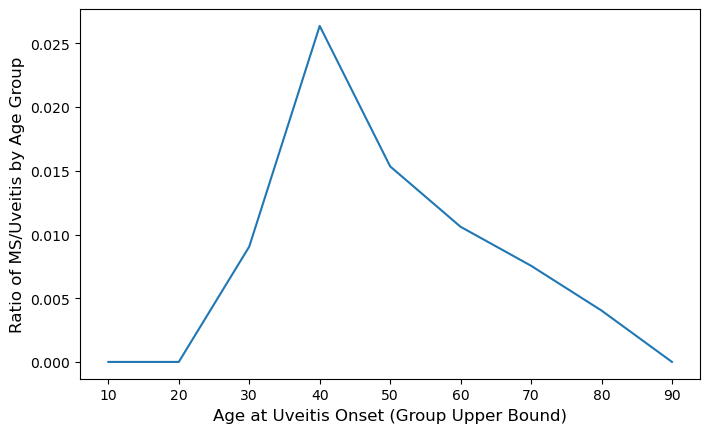

In [29]:
plot_age_dist(data, "MS_any", plot_ratio=True)

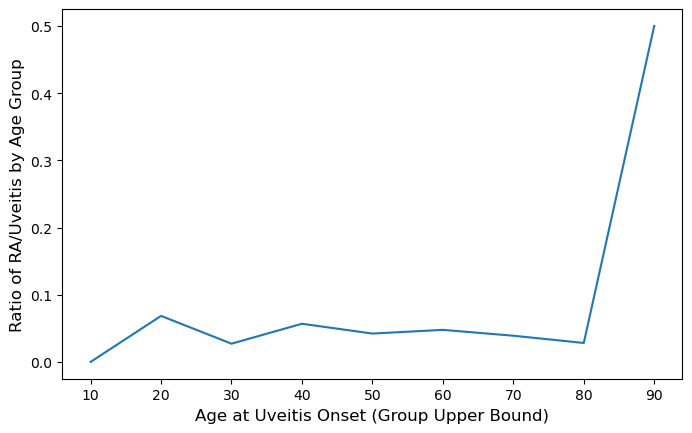

In [21]:
plot_age_dist(data, "RA_any", plot_ratio=True)

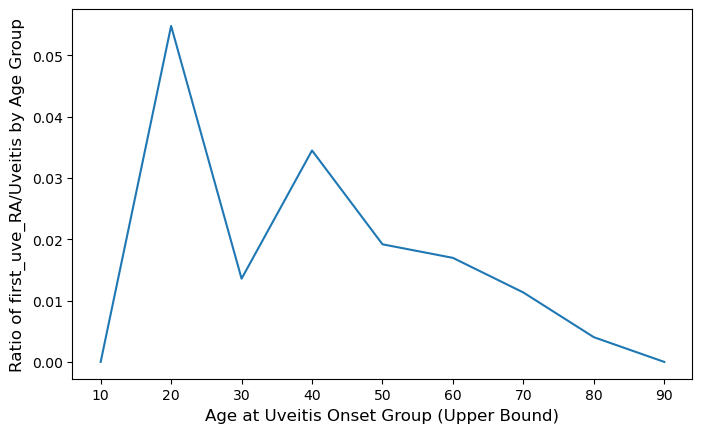

In [19]:
plot_age_dist(data, "first_uve_RA", plot_ratio=True)

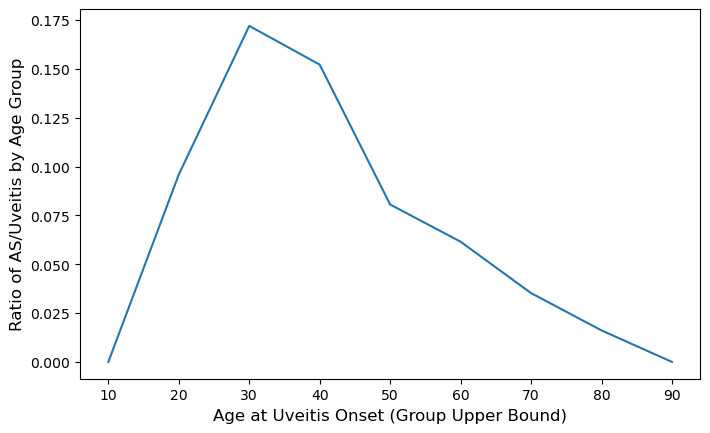

In [22]:
plot_age_dist(data, "AS_any", plot_ratio=True)

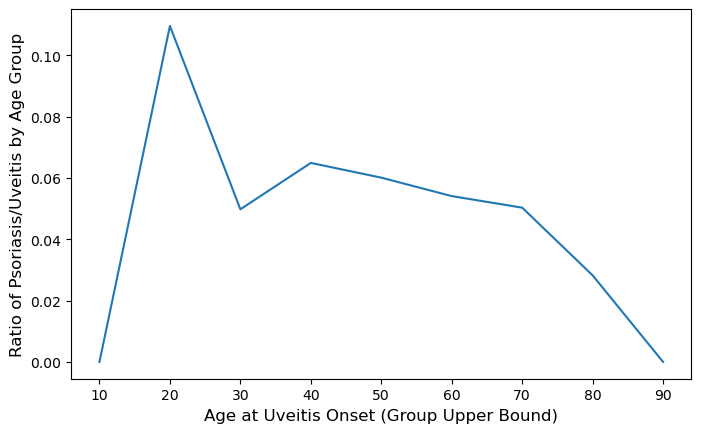

In [23]:
plot_age_dist(data, "Psoriasis_any", plot_ratio=True)

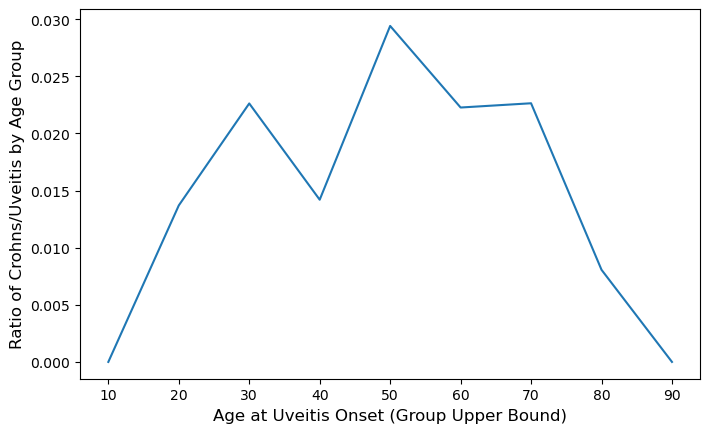

In [24]:
plot_age_dist(data, "Crohns_any", plot_ratio=True)

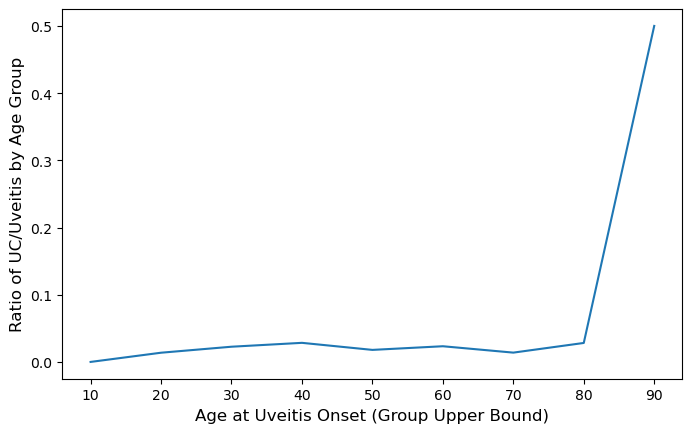

In [25]:
plot_age_dist(data, "UC_any", plot_ratio=True)

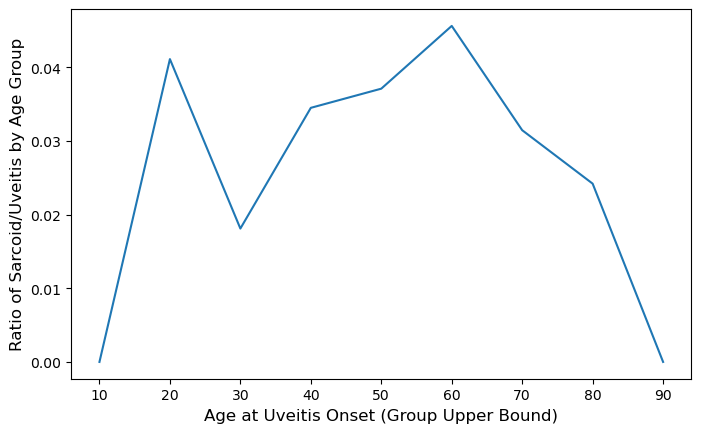

In [27]:
plot_age_dist(data, "Sarcoid_any", plot_ratio=True)

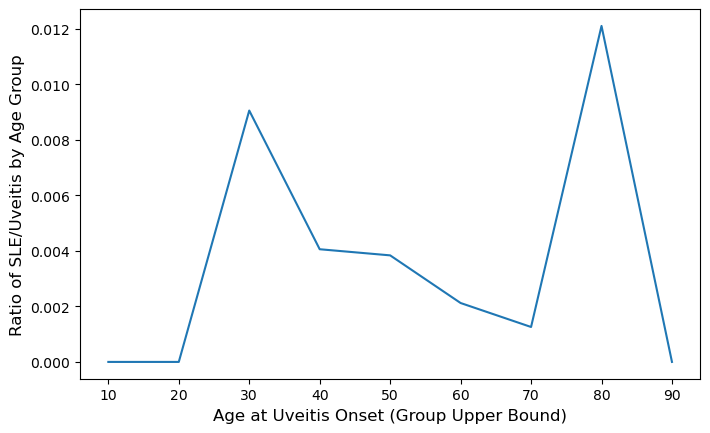

In [28]:
plot_age_dist(data, "SLE_any", plot_ratio=True)

### Survival Analysis

In [ ]:
# Define font styles for ticks on axes
tick_font = {
    'family': 'sans-serif',  # Font family for the tick labels
    'weight': 'medium',  # Font weight for the tick labels (e.g., 'medium')
    'size': 7,  # Font size for the tick labels
}

# Define font styles for labels
label_font = {
    'family': 'sans-serif',  # Font family for the label text
    'weight': 'medium',  # Font weight for the label text (e.g., 'medium')
    'size': 10,  # Font size for the label text
}

# Set the font style for tick labels using the defined 'tick_font'
plt.rc('font', **tick_font)

# Define the width of a figure with double-column layout (for publishing requirements)
double_col_width = 7.0867

# Define the width of a figure with single-column layout (for publishing requirements)
col_width = 3.46457

In [ ]:
colors = {
    'Controls': 'lightgreen',
    'MS only': 'orange',
    'Uve': 'red',
    'MS-Uve': 'steelblue'
}

# Create a figure and an axes object
fig, ax = plt.subplots()
grsplot.plot_violin(data, 'MS_any', 'MS_GRS', 'uve_any', ax, colors=colors)

In [ ]:
# Define color mapping if needed
colors = {
    'Controls': 'gray',
    'MS only': 'blue',
    'Uve': 'green',
    'MS-Uve': 'red'
}

# Create a figure and an axes object
fig, ax = plt.subplots()

# Call the function from your module
grsplot.plot_grs(data, 'MS_any', 'MS_GRS', 'uve_any', ax, colors=colors)

In [ ]:
# # Define color mapping if needed
# colors = {
#     'Controls': 'gray',
#     'RA only': 'blue',
#     'Uve': 'green',
#     'RA-Uve': 'red'
# }

# # Create a figure and an axes object
# fig, ax = plt.subplots()

# # Call the function from your module
# grsplot.plot_grs(data, 'RA_any', 'RhA_GRS', 'uve_any', ax, colors=colors)

# Survival modelling: Cox Proportional Hazard

In [14]:
from  survival_analysis.stratifiedKM_plot import *
from survival_analysis.utilities_mod import *

import survival_analysis.model_fitter
import survival_analysis.backward_elimination 

In [15]:
importlib.reload(survival_analysis.model_fitter)
from survival_analysis.model_fitter import *

### Single models plotting

In [ ]:
cph, cph_data = fit_and_show_cph(data, 'AS_any', "AS_GRS",
                            age_col='age_uve_years',
#                            get_dummies='age_group_uve',
                            add_columns=['Sex_Female'])

In [ ]:
fit_and_show_cph(data, 'MS_any', "MS_GRS", age_col='age_uve_binary')

In [ ]:
fit_and_show_cph(data, 'SLE_any', "SLE_GRS", add_columns=['white_british', 'Sex_Female'])

In [ ]:
fit_and_show_cph(data, 'UC_any', "IBD_GRS", add_columns=['Sex_Female'],
                 duration_col='uve_to_IBD_years', event_col='first_uve_UC')

In [ ]:
fit_and_show_cph(data, 'RA_any', "RhA_GRS")

In [ ]:
cph, cph_data = fit_and_show_cph(data, 'Psoriasis_any', "Psoriasis_GRS", return_model=True)

In [ ]:
cph, cph_data = fit_and_show_cph(data, 'Psoriasis_any', "Psoriasis_GRS",
                                 age_col='age_group_uve', get_dummies='age_group_uve')

In [ ]:
fit_and_show_cph(data, 'Sarcoid_any', "Sarcoid_GRS")

In [ ]:
fit_and_show_cph(data, 'AS_any', "AS_GRS")

In [ ]:
data = pd.get_dummies(data, columns=['B27'], drop_first=False)


In [ ]:
fit_and_show_cph(data, 'AS_any', "B27_1.0", add_columns=['Sex_Female'])

In [ ]:
fit_and_show_cph(data, 'Crohns_any', "IBD_GRS", add_columns=['Sex_Female'],
                 duration_col='uve_to_IBD_years', event_col='first_uve_Crohns')

## Backward Elimination

In [16]:
importlib.reload(survival_analysis.backward_elimination)
from survival_analysis.backward_elimination import *
importlib.reload(survival_analysis.model_fitter)
from survival_analysis.model_fitter import *

## Linear: UC, Psoriasis and RhA

### Psoriasis

In [17]:
add_columns = ['Sex_Female', 'BMI', 'ever_smoked_yes', 'TDI', 'MS_GRS', 'AS_GRS',
               'RhA_GRS', 'IBD_GRS', 'SLE_GRS', 'Sarcoid_GRS',
               'white_british']

cph_psoriasis, psoriasis_df = prepare_and_save_model(
    data, 'Psoriasis_any', 'Psoriasis_GRS',
    'first_uve_Psoriasis', 'uve_to_Psoriasis_years',
    'age_uve_years', add_columns, 'final_models', penalizer=0.001
)

Disease formatted as Psoriasis
first_uve_Psoriasis
uve_to_Psoriasis_years
Removed Sarcoid_GRS with p-value: 0.6892421876876929
Removed AS_GRS with p-value: 0.4296260723440454
Removed IBD_GRS with p-value: 0.46287213184491294
Removed white_british with p-value: 0.33407890350975034
Removed ever_smoked_yes with p-value: 0.26527539784438486
Removed MS_GRS with p-value: 0.2546424855390402
Removed BMI with p-value: 0.1763747257339053
Removed RhA_GRS with p-value: 0.13505445903651944
Removed SLE_GRS with p-value: 0.05054911663601846
No further improvements; p-values are below the significance level.
Backward elimination based on P-value completed.Features reminaing: ['age_uve_years', 'Sex_Female', 'Psoriasis_GRS', 'TDI'] 

Initial model with all features AIC: 1180.0559731037672
No further improvement; best acheived was 1183.301457121946
stopping elimination.
Proportional hazard assumption looks okay.
Model saved to final_models/Psoriasis_any_finalised_model_2024-08-20.pkl


/slade/home/pl450/miniconda3/lib/python3.9/site-packages/lifelines/fitters/mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  for variable in self.params_.index & (columns or self.params_.index):


In [18]:
cph_psoriasis.print_summary()
cph_psoriasis.summary

<lifelines.CoxPHFitter: fitted with 3445 total observations, 3366 right-censored observations>
             duration col = 'uve_to_Psoriasis_years'
                event col = 'first_uve_Psoriasis'
      baseline estimation = breslow
   number of observations = 3445
number of events observed = 79
   partial log-likelihood = -586.03
         time fit was run = 2024-08-20 21:10:46 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
Psoriasis_GRS   0.27       1.31       0.11             0.05             0.49                 1.05                 1.63
TDI             0.08       1.08       0.03             0.01             0.15                 1.01                 1.16
age_uve_years  -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
Sex_Female     -0.33       0.72       0.23            -0.77             0.12                 0.46                 1.13

                  z    p   -log2(p)
covariate                          
Psoriasis_GRS  2.44 0.01       6.10
TDI            2.36 0.02       5.79
age_uve_years -0.23 0.82       0.29
Sex_Female    -1.42 0.16       2.68
---
Concordance = 0.60
Partial AIC = 1180.06
log-likelihood ratio test = 13.50 on 4 df
-log2(p) of ll-ratio test = 6.79

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
Psoriasis_GRS,0.269933,1.309877,0.110478,0.053400,0.486466,1.054852,1.626558,2.443320,0.014553,6.102558
TDI,0.080452,1.083777,0.034034,0.013748,0.147157,1.013843,1.158536,2.363908,0.018083,5.789200
age_uve_years,-0.002129,0.997873,0.009156,-0.020075,0.015818,0.980125,1.015943,-0.232488,0.816159,0.293078
Sex_Female,-0.325143,0.722424,0.228965,-0.773906,0.123620,0.461208,1.131586,-1.420054,0.155592,2.684161


### Ulcerative Colitis

In [19]:
add_columns = ['Sex_Female', 'BMI', 'ever_smoked_yes', 'TDI',
               'MS_GRS',
               'AS_GRS', 'Psoriasis_GRS',
               'RhA_GRS', 'SLE_GRS', 'Sarcoid_GRS',
               'white_british']

cph_uc, uc_df = prepare_and_save_model(
    data, 'UC_any', 'IBD_GRS',
    'first_uve_UC', 'uve_to_IBD_years',
    'age_uve_years', add_columns, 'final_models', penalizer=0.00
)

Disease formatted as UC
first_uve_UC
uve_to_IBD_years
Removed Psoriasis_GRS with p-value: 0.5964645632948143
Removed RhA_GRS with p-value: 0.5591335441511429
Removed MS_GRS with p-value: 0.5683211641948096
Removed SLE_GRS with p-value: 0.5831971587825773
Removed ever_smoked_yes with p-value: 0.4444897049771992
Removed AS_GRS with p-value: 0.29741819508624756
Removed white_british with p-value: 0.2714526133415033
Removed TDI with p-value: 0.3569977526417726
Removed BMI with p-value: 0.10383517605265129
Removed Sarcoid_GRS with p-value: 0.05239154815263762
No further improvements; p-values are below the significance level.
Backward elimination based on P-value completed.Features reminaing: ['age_uve_years', 'Sex_Female', 'IBD_GRS'] 

Initial model with all features AIC: 311.0514643222185
No further improvement; best acheived was 316.4896381149319
stopping elimination.
Proportional hazard assumption looks okay.
Model saved to final_models/UC_any_finalised_model_2024-08-20.pkl


/slade/home/pl450/miniconda3/lib/python3.9/site-packages/lifelines/fitters/mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  for variable in self.params_.index & (columns or self.params_.index):


In [20]:
cph_uc.print_summary()
cph_uc.summary

<lifelines.CoxPHFitter: fitted with 3508 total observations, 3487 right-censored observations>
             duration col = 'uve_to_IBD_years'
                event col = 'first_uve_UC'
      baseline estimation = breslow
   number of observations = 3508
number of events observed = 21
   partial log-likelihood = -152.53
         time fit was run = 2024-08-20 21:10:47 UTC

---
                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                             
IBD_GRS         0.57       1.78       0.21             0.16             0.99                 1.18                 2.68
age_uve_years  -0.04       0.96       0.02            -0.08            -0.01                 0.93                 0.99
Sex_Female      0.40       1.49       0.44            -0.47             1.27                 0.63                 3.56

                  z    p   -log2(p)
covariate                          
IBD_GRS        2.73 0.01       7.32
age_uve_years -2.44 0.01       6.11
Sex_Female     0.90 0.37       1.45
---
Concordance = 0.76
Partial AIC = 311.05
log-likelihood ratio test = 14.19 on 3 df
-log2(p) of ll-ratio test = 8.56

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
IBD_GRS,0.574994,1.777121,0.210321,0.162773,0.987216,1.176769,2.683753,2.733890,0.006259,7.319830
age_uve_years,-0.041956,0.958912,0.017160,-0.075590,-0.008322,0.927196,0.991712,-2.444940,0.014488,6.109034
Sex_Female,0.401179,1.493585,0.443521,-0.468106,1.270465,0.626187,3.562508,0.904533,0.365713,1.451216


### Rheumatoid Arthritis

In [21]:
add_columns = ['Sex_Female', 'BMI', 'ever_smoked_yes', 'TDI',
               'MS_GRS', 'IBD_GRS',
               'AS_GRS', 'Psoriasis_GRS',
#               'SLE_GRS',
               'Sarcoid_GRS', 
               'white_british']

cph_ra, ra_df = prepare_and_save_model(
    data, 'RA_any', 'RhA_GRS',
    'first_uve_RA', 'uve_to_RA_years',
    'age_uve_years', add_columns, 'final_models', penalizer=0.000
)


Disease formatted as RA
first_uve_RA
uve_to_RA_years
Removed Sarcoid_GRS with p-value: 0.8877162019358487
Removed MS_GRS with p-value: 0.7092878139860039
Removed Psoriasis_GRS with p-value: 0.5376209947798756
Removed white_british with p-value: 0.2993427817538512
Removed IBD_GRS with p-value: 0.25419094926270897
Removed TDI with p-value: 0.13857804664273743
No further improvements; p-values are below the significance level.
Backward elimination based on P-value completed.Features reminaing: ['age_uve_years', 'Sex_Female', 'RhA_GRS', 'BMI', 'ever_smoked_yes', 'AS_GRS'] 

Initial model with all features AIC: 954.5425524544355
No further improvement; best acheived was 956.4904935830535
stopping elimination.
Proportional hazard assumption looks okay.
Model saved to final_models/RA_any_finalised_model_2024-08-20.pkl


/slade/home/pl450/miniconda3/lib/python3.9/site-packages/lifelines/fitters/mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  for variable in self.params_.index & (columns or self.params_.index):


In [22]:
cph_ra.print_summary()
cph_ra.summary

<lifelines.CoxPHFitter: fitted with 3471 total observations, 3406 right-censored observations>
             duration col = 'uve_to_RA_years'
                event col = 'first_uve_RA'
      baseline estimation = breslow
   number of observations = 3471
number of events observed = 65
   partial log-likelihood = -471.27
         time fit was run = 2024-08-20 21:10:49 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
RhA_GRS           0.39       1.48       0.12             0.16             0.63                 1.17                 1.87
BMI               0.08       1.08       0.02             0.04             0.12                 1.04                 1.13
ever_smoked_yes   0.50       1.65       0.26             0.00             1.00                 1.00                 2.73
AS_GRS            0.29       1.33       0.08             0.13             0.44                 1.13                 1.56
age_uve_years     0.01       1.01       0.01            -0.01             0.03                 0.99                 1.04
Sex_Female        0.04       1.04       0.25            -0.45             0.54                 0.64                 1.71

                   z      p   -log2(p)
covariate                             
RhA_GRS         3.25 <0.005       9.75
BMI             4.05 <0.005      14.26
ever_smoked_yes 1.96   0.05       4.34
AS_GRS          3.50 <0.005      11.09
age_uve_years   1.27   0.21       2.29
Sex_Female      0.16   0.87       0.20
---
Concordance = 0.71
Partial AIC = 954.54
log-likelihood ratio test = 41.23 on 6 df
-log2(p) of ll-ratio test = 21.87

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
RhA_GRS,0.392042,1.479999,0.120678,0.155517,0.628567,1.168261,1.874921,3.248653,0.001160,9.752247
BMI,0.080981,1.084351,0.019991,0.041799,0.120164,1.042685,1.127681,4.050827,0.000051,14.258100
ever_smoked_yes,0.502636,1.653073,0.255803,0.001272,1.004000,1.001273,2.729176,1.964936,0.049422,4.338712
AS_GRS,0.285001,1.329763,0.081348,0.125562,0.444439,1.133785,1.559615,3.503485,0.000459,11.088549
age_uve_years,0.013648,1.013742,0.010770,-0.007460,0.034756,0.992568,1.035367,1.267284,0.205054,2.285926
Sex_Female,0.040833,1.041678,0.252336,-0.453736,0.535402,0.635250,1.708135,0.161819,0.871448,0.198513


## Non-linear Age: MS, AS, Sarcoidosis, Crohns, SLE

In [23]:
add_columns = ['Sex_Female', 'BMI', 'ever_smoked_yes', 'TDI',
               'MS_GRS', 'IBD_GRS',
               'RhA_GRS', 'Psoriasis_GRS',
               'SLE_GRS',
               'Sarcoid_GRS',
               'white_british']

cph_as, as_df = prepare_and_save_model(
    data, 'AS_any', 'AS_GRS',
    'first_uve_AS', 'uve_to_AS_years',
    'age_uve_binary', add_columns, 'final_models', penalizer=0.001
)


Disease formatted as AS
first_uve_AS
uve_to_AS_years
Removed IBD_GRS with p-value: 0.933358864729168
Removed Sarcoid_GRS with p-value: 0.8736649589201679
Removed BMI with p-value: 0.85548183795791
Removed RhA_GRS with p-value: 0.8033728079101207
Removed white_british with p-value: 0.7290215293493789
Removed MS_GRS with p-value: 0.6921666550997425
Removed SLE_GRS with p-value: 0.693763183917548
Removed ever_smoked_yes with p-value: 0.6940758787011694
Removed TDI with p-value: 0.6390893964058169
Removed Psoriasis_GRS with p-value: 0.2207793337838736
No further improvements; p-values are below the significance level.
Backward elimination based on P-value completed.Features reminaing: ['age_uve_binary', 'Sex_Female', 'AS_GRS'] 

Initial model with all features AIC: 1218.907774282194
No further improvement; best acheived was 1280.6661315812717
stopping elimination.
Proportional hazard assumption looks okay.
Model saved to final_models/AS_any_finalised_model_2024-08-20.pkl


/slade/home/pl450/miniconda3/lib/python3.9/site-packages/lifelines/fitters/mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  for variable in self.params_.index & (columns or self.params_.index):


In [24]:
cph_as.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
AS_GRS,0.559651,1.750062,0.068242,0.425898,0.693404,1.530965,2.000514,8.200922,2.385505e-16,51.896555
age_uve_binary,0.765115,2.149241,0.258640,0.258190,1.272039,1.294585,3.568122,2.958227,3.094142e-03,8.336245
Sex_Female,-0.410285,0.663461,0.225016,-0.851309,0.030738,0.426856,1.031215,-1.823360,6.824891e-02,3.873050


### Multiple Sclerosis

In [25]:
# fit_and_show_cph(data, 'UC_any', "IBD_GRS", add_columns=['Sex_Female'],
#                  duration_col='uve_to_IBD_years', event_col='first_uve_UC')

add_columns = ['Sex_Female', 'BMI', 'ever_smoked_yes', 'TDI',
               'AS_GRS', 'IBD_GRS',
               'RhA_GRS', 'Psoriasis_GRS',
               'SLE_GRS',
               # 'Sarcoid_GRS',
               'white_british']

cph_ms, ms_df = prepare_and_save_model(
    data, 'MS_any', 'MS_GRS',
    'first_uve_MS', 'uve_to_MS_years',
    'age_uve_binary', add_columns, 'final_models', penalizer=0.00
)

Disease formatted as MS
first_uve_MS
uve_to_MS_years
Removed white_british with p-value: 0.9943607569511694
Removed IBD_GRS with p-value: 0.9138489015747054
Removed AS_GRS with p-value: 0.8231556253993877
Removed Psoriasis_GRS with p-value: 0.5839867756833212
Removed ever_smoked_yes with p-value: 0.4219224142476623
Removed BMI with p-value: 0.320221762067223
Removed TDI with p-value: 0.3870712006582281
Removed SLE_GRS with p-value: 0.2264672023749927
Removed RhA_GRS with p-value: 0.06772759993281782
No further improvements; p-values are below the significance level.
Backward elimination based on P-value completed.Features reminaing: ['age_uve_binary', 'Sex_Female', 'MS_GRS'] 

Initial model with all features AIC: 340.3040320157113
No further improvement; best acheived was 357.52738786041664
stopping elimination.
Proportional hazard assumption looks okay.
Model saved to final_models/MS_any_finalised_model_2024-08-20.pkl


/slade/home/pl450/miniconda3/lib/python3.9/site-packages/lifelines/fitters/mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  for variable in self.params_.index & (columns or self.params_.index):


In [26]:
cph_ms.print_summary()

<lifelines.CoxPHFitter: fitted with 3542 total observations, 3518 right-censored observations>
             duration col = 'uve_to_MS_years'
                event col = 'first_uve_MS'
      baseline estimation = breslow
   number of observations = 3542
number of events observed = 24
   partial log-likelihood = -167.15
         time fit was run = 2024-08-20 21:10:52 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
MS_GRS           0.87       2.40       0.20             0.49             1.26                 1.63                 3.51
age_uve_binary   1.40       4.07       0.56             0.30             2.50                 1.35                12.21
Sex_Female       0.96       2.60       0.45             0.07             1.84                 1.08                 6.28

                  z      p   -log2(p)
covariate                            
MS_GRS         4.48 <0.005      17.02
age_uve_binary 2.50   0.01       6.33
Sex_Female     2.13   0.03       4.90
---
Concordance = 0.79
Partial AIC = 340.30
log-likelihood ratio test = 31.42 on 3 df
-log2(p) of ll-ratio test = 20.46

### Sarcoidosis

In [27]:
add_columns = ['Sex_Female', 'BMI', 'ever_smoked_yes', 'TDI',
               # 'MS_GRS',
               'IBD_GRS',
               'RhA_GRS', 'Psoriasis_GRS',
               'SLE_GRS', 'AS_GRS', 'white_british']

cph_sarcoid, sarcoid_df = prepare_and_save_model(
    data, 'Sarcoid_any', 'Sarcoid_GRS',
    'first_uve_Sarcoid', 'uve_to_Sarcoid_years',
    'age_uve_binary', add_columns, 'final_models', penalizer=0.000
)

Disease formatted as Sarcoid
first_uve_Sarcoid
uve_to_Sarcoid_years
Removed BMI with p-value: 0.845884428434719
Removed SLE_GRS with p-value: 0.6870907731007385
Removed TDI with p-value: 0.377946561871637
Removed white_british with p-value: 0.1715658566353122
Removed Psoriasis_GRS with p-value: 0.12464362702079987
Removed ever_smoked_yes with p-value: 0.09595087521945789
Removed RhA_GRS with p-value: 0.08368154952348304
Removed AS_GRS with p-value: 0.0702921731696057
Removed IBD_GRS with p-value: 0.09840934541391111
No further improvements; p-values are below the significance level.
Backward elimination based on P-value completed.Features reminaing: ['age_uve_binary', 'Sex_Female', 'Sarcoid_GRS'] 

Initial model with all features AIC: 751.2537572287187
No further improvement; best acheived was 754.5158662094605
stopping elimination.
Proportional hazard assumption looks okay.
Model saved to final_models/Sarcoid_any_finalised_model_2024-08-20.pkl


/slade/home/pl450/miniconda3/lib/python3.9/site-packages/lifelines/fitters/mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  for variable in self.params_.index & (columns or self.params_.index):


In [28]:
cph_sarcoid.print_summary()

<lifelines.CoxPHFitter: fitted with 3482 total observations, 3435 right-censored observations>
             duration col = 'uve_to_Sarcoid_years'
                event col = 'first_uve_Sarcoid'
      baseline estimation = breslow
   number of observations = 3482
number of events observed = 47
   partial log-likelihood = -372.63
         time fit was run = 2024-08-20 21:10:53 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
Sarcoid_GRS      0.35       1.41       0.15             0.04             0.65                 1.04                 1.91
age_uve_binary   0.44       1.55       0.30            -0.15             1.03                 0.86                 2.80
Sex_Female       0.10       1.11       0.29            -0.47             0.68                 0.62                 1.97

                  z    p   -log2(p)
covariate                          
Sarcoid_GRS    2.23 0.03       5.28
age_uve_binary 1.47 0.14       2.81
Sex_Female     0.35 0.72       0.46
---
Concordance = 0.63
Partial AIC = 751.25
log-likelihood ratio test = 7.12 on 3 df
-log2(p) of ll-ratio test = 3.88

In [29]:
cph_sarcoid.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
Sarcoid_GRS,0.345282,1.412388,0.154890,0.041704,0.648861,1.042586,1.913359,2.229213,0.025800,5.276499
age_uve_binary,0.440824,1.553987,0.300753,-0.148642,1.030290,0.861878,2.801878,1.465732,0.142721,2.808728
Sex_Female,0.103269,1.108789,0.293082,-0.471162,0.677699,0.624276,1.969341,0.352354,0.724573,0.464797


### Crohns

In [30]:
add_columns = ['Sex_Female', 'BMI', 'ever_smoked_yes', 'TDI',
               'MS_GRS', 'SLE_GRS',
               'RhA_GRS', 'Psoriasis_GRS',
               'Sarcoid_GRS', 'AS_GRS',
               'white_british']

cph_crohns, crohns_df = prepare_and_save_model(
    data, 'Crohns_any', 'IBD_GRS',
    'first_uve_IBD', 'uve_to_IBD_years', 'age_uve_binary',
    add_columns, 'final_models', penalizer=0.00
)

Disease formatted as Crohns
first_uve_IBD
uve_to_IBD_years
Removed MS_GRS with p-value: 0.9590241085910889
Removed Psoriasis_GRS with p-value: 0.6604096344937788
Removed TDI with p-value: 0.5976557866166379
Removed white_british with p-value: 0.43722539551371675
Removed RhA_GRS with p-value: 0.4256810260064384
Removed SLE_GRS with p-value: 0.35334297185286456
Removed IBD_GRS with p-value: 0.26377603565995433
Removed Sarcoid_GRS with p-value: 0.21008325276811762
Removed BMI with p-value: 0.18601397131327788
Removed ever_smoked_yes with p-value: 0.20036405157841441
Removed AS_GRS with p-value: 0.13212080103492158
Backward elimination based on P-value completed.Features reminaing: ['age_uve_binary', 'Sex_Female'] 

Initial model with all features AIC: 636.2168542201978
Proportional hazard assumption looks okay.
Model saved to final_models/Crohns_any_finalised_model_2024-08-20.pkl


/slade/home/pl450/miniconda3/lib/python3.9/site-packages/lifelines/fitters/mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  for variable in self.params_.index & (columns or self.params_.index):


In [31]:
cph_crohns.print_summary()

<lifelines.CoxPHFitter: fitted with 3515 total observations, 3473 right-censored observations>
             duration col = 'uve_to_IBD_years'
                event col = 'first_uve_IBD'
      baseline estimation = breslow
   number of observations = 3515
number of events observed = 42
   partial log-likelihood = -316.11
         time fit was run = 2024-08-20 21:10:54 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
age_uve_binary   0.76       2.13       0.37             0.04             1.47                 1.04                 4.36
Sex_Female       0.42       1.53       0.32            -0.19             1.04                 0.82                 2.84

                  z    p   -log2(p)
covariate                          
age_uve_binary 2.07 0.04       4.70
Sex_Female     1.35 0.18       2.49
---
Concordance = 0.62
Partial AIC = 636.22
log-likelihood ratio test = 6.24 on 2 df
-log2(p) of ll-ratio test = 4.50

## Plotting models prediction

In [32]:
models = [cph_as, cph_ra, cph_psoriasis, cph_sarcoid, cph_uc, cph_ms]
dfs = [as_df, ra_df, psoriasis_df, sarcoid_df, uc_df, ms_df]

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

PPTX = False


colours = ['darkorange', 'orangered', 'darkmagenta', 'steelblue']
markersize = 10  # Adjust this value as needed
label_font = {'fontsize': 9, 'fontweight': 'regular'}  # Adjust as needed


if not PPTX:
    plt.figure(figsize=[7, 10], dpi=300)
elif PPTX:
    plt.figure(figsize=[10, 7], dpi=300)

for i, (model, df) in enumerate(zip(models, dfs)):
    
    if not PPTX:
        plt.subplot(3, 2, i+1)
    elif PPTX:
        plt.subplot(2, 3, i+1)
    
    df['cph_prediction'] = model.predict_partial_hazard(df)
    df_ci = proportion_ci(stratify_kmf(df), model.event_col,
                          model.duration_col)*100

    for y, (x, colour) in enumerate(zip(['1st', '2nd', '3rd', '4th'],
                                        colours)):
        
        plt.plot([x, x], [df_ci.loc[y].lower_ci5, df_ci.loc[y].upper_ci5],
                 color=colour, linewidth=1.5)
        plt.plot([x], [df_ci.loc[y].proportion5], color=colour,
                 marker='s', markersize=markersize, markeredgecolor='black')

        plt.plot([y+0.15, y+0.15], [df_ci.loc[y].lower_ci10,
                                    df_ci.loc[y].upper_ci10],
                 color=colour, linewidth=1.5, alpha=0.8)
        
        plt.plot([y+0.15], [df_ci.loc[y].proportion10], color=colour,
                 marker='o', markersize=markersize,
                 markeredgecolor='black', alpha=0.8)

        plt.plot([y+0.30, y+0.30], [df_ci.loc[y].lower_ci20,
                                    df_ci.loc[y].upper_ci20],
                 color=colour, linewidth=1.5, alpha=0.7)
        
        plt.plot([y+0.30], [df_ci.loc[y].proportion20], color=colour,
                 marker='v', markersize=markersize,
                 markeredgecolor='black', alpha=0.7)

        plt.plot([y+0.44, y+0.44], [df_ci.loc[y].lower_ci50,
                                    df_ci.loc[y].upper_ci50],
                 color=colour, linewidth=1.5, alpha=0.6)
        plt.plot([y+0.44], [df_ci.loc[y].proportion50], color=colour,
                 marker='X', markersize=markersize,
                 markeredgecolor='black', alpha=0.6)
    
    dis = model.event_col.lstrip("first_uve_")
    plt.xlabel(f'Quartile of predicted {dis} risk',
               fontdict=label_font)
    plt.ylabel(f'% diagnosed with {dis} (95% CI)', fontdict=label_font)
    if PPTX:
        if i < 3:
            plt.ylim([-0, 8.5])
        elif i <3:
            plt.ylim([-0, 3])
        
    elif not PPTX:
        if i < 2:
            plt.ylim([-0, 8.5])
        elif i <4:
            plt.ylim([-0, 6])
        else:
            plt.ylim([0, 3])
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
    plt.title(f'{model.event_col.lstrip("first_uve_")}', fontdict=label_font)

# Create legend
    legend_elements = [
        Line2D([0], [0], marker='X', color='white', label='At end of follow-up',
               markerfacecolor='dimgray', markersize=9),
        Line2D([0], [0], marker='v', color='white', label='At 20 years',
               markerfacecolor='dimgray', markersize=9),
        Line2D([0], [0], marker='o', color='white', label='At 10 years',
               markerfacecolor='dimgray', markersize=9),
        Line2D([], [], marker='s', color='white', label='At 5 years',
               markerfacecolor='dimgray', markersize=9),
    ]

    plt.legend(handles=legend_elements, fontsize=8, frameon=False, loc='upper left')

plt.tight_layout()
savelabel = 'quartile_risk_6models' + ('' if not PPTX else 'pptx') + '_130824.svg'
plt.savefig(f'cph_summaries/{savelabel}')
plt.show()

In [34]:
for i, (model, df) in enumerate(zip(models, dfs)):

    
    df['cph_prediction'] = model.predict_partial_hazard(df)
    strat_df = stratify_kmf(df)

    df_ci = proportion_ci(strat_df,model.event_col, model.duration_col )*100
    
    print(model.event_col)
    print(int(strat_df[0][model.event_col].sum()),
          '/',len(strat_df[0][model.event_col]), sep='')
    
    print(f"{df_ci.loc[0, 'proportion50']:.1f}% (" +
          f"{df_ci.loc[0, 'lower_ci50']:.1f}–{df_ci.loc[0, 'upper_ci50']:.1f})")
    
    print(f"{df_ci.loc[3, 'proportion50']:.1f}% (" +
          f"{df_ci.loc[3, 'lower_ci50']:.1f}-{df_ci.loc[3, 'upper_ci50']:.1f})")
    print(int(strat_df[3][model.event_col].sum()),
          '/',len(strat_df[3][model.event_col]), sep='')
    print('\n')



first_uve_AS
3/843
0.4% (-0.0–0.8)
7.5% (5.7-9.2)
63/843


first_uve_RA
5/868
0.6% (0.1–1.1)
3.6% (2.3-4.8)
31/868


first_uve_Psoriasis
11/862
1.3% (0.5–2.0)
4.2% (2.8-5.5)
36/861


first_uve_Sarcoid
6/905
0.7% (0.1–1.2)
2.4% (1.4-3.4)
21/870


first_uve_UC
0/877
0.0% (0.0–0.0)
1.7% (0.9-2.6)
15/877


first_uve_MS
0/886
0.0% (0.0–0.0)
1.9% (1.0-2.8)
17/886




In [33]:
from survival_analysis.calibration_lifelines import survival_probability_calibration
importlib.reload(survival_analysis.calibration_lifelines)
from survival_analysis.calibration_lifelines import survival_probability_calibration

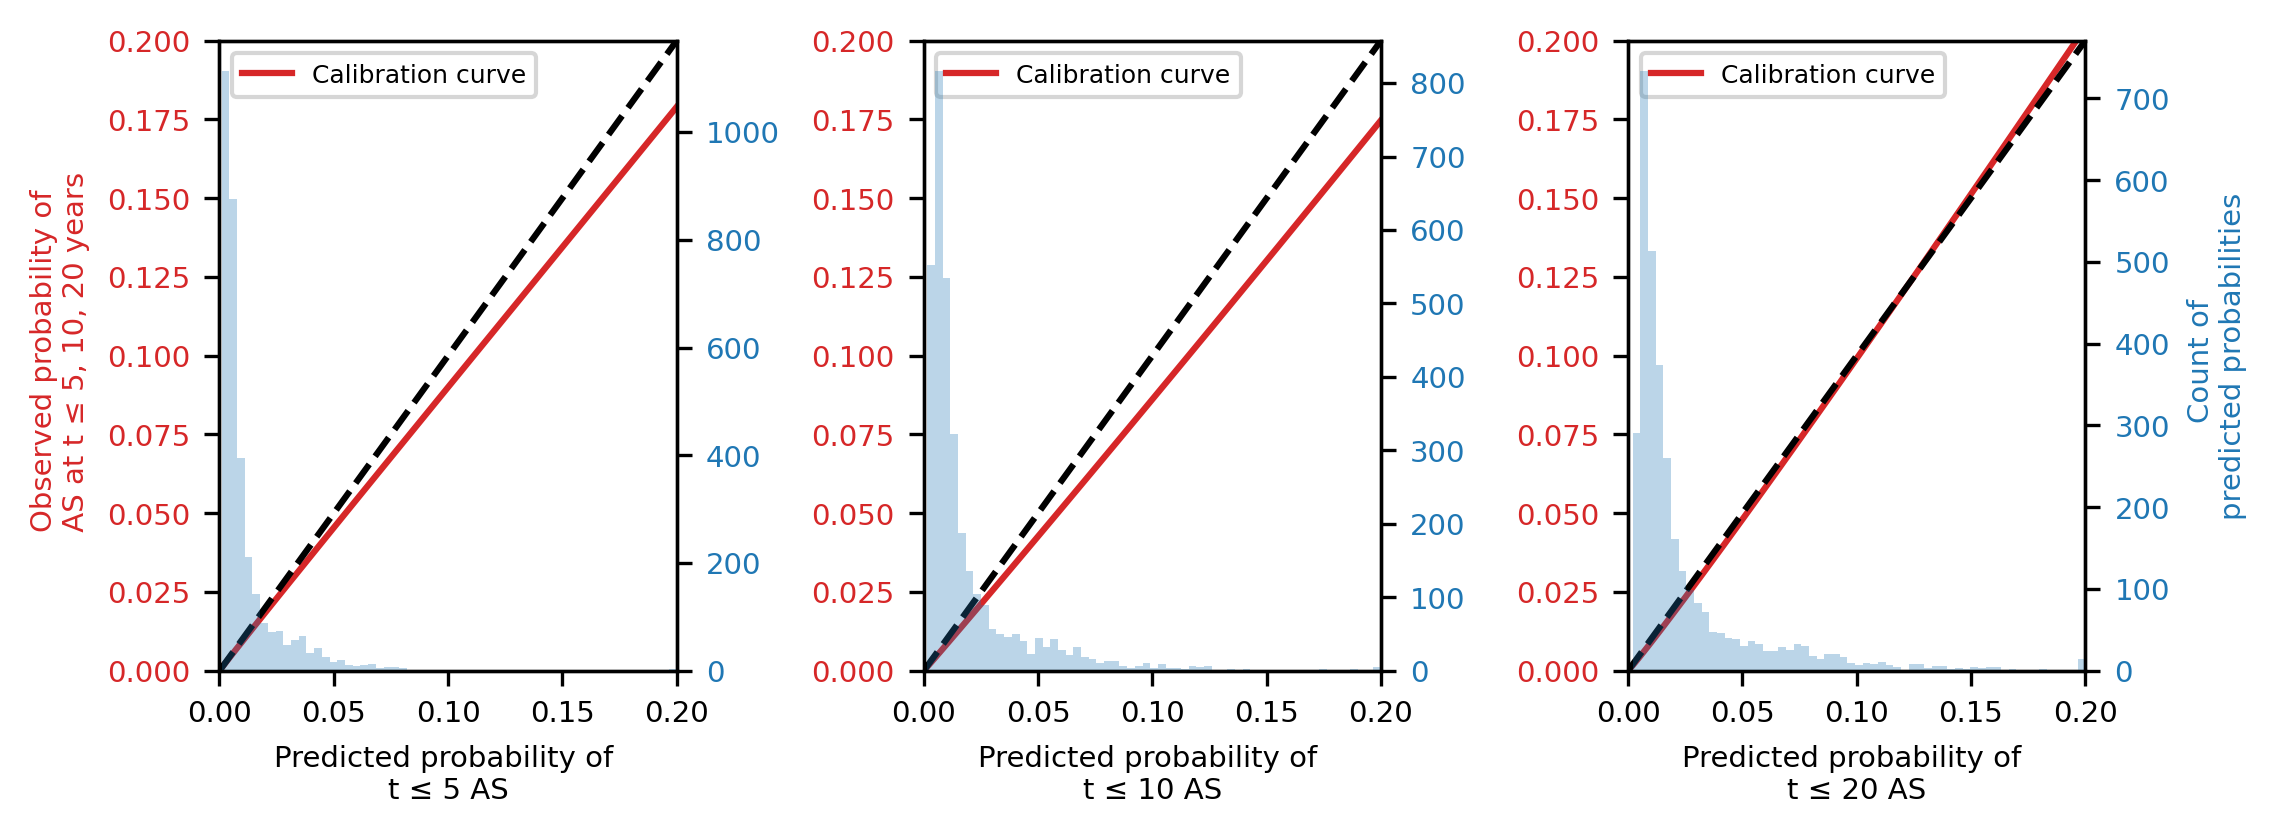

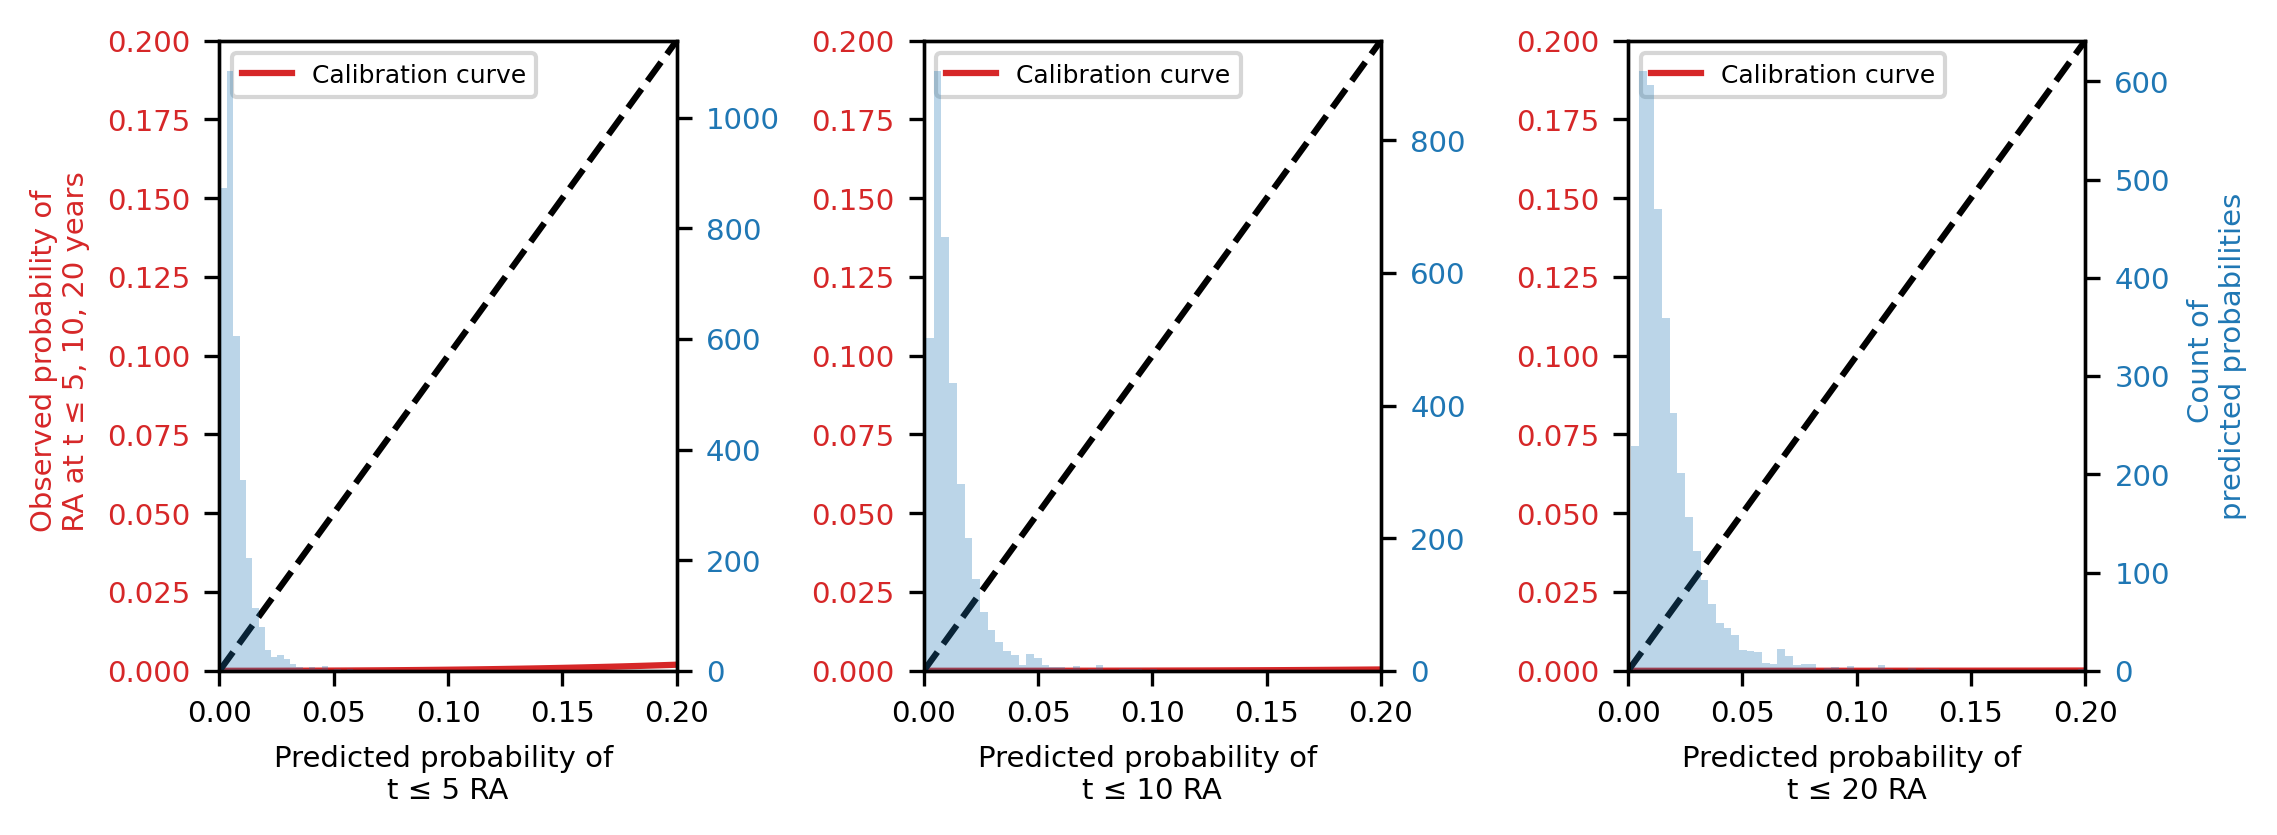

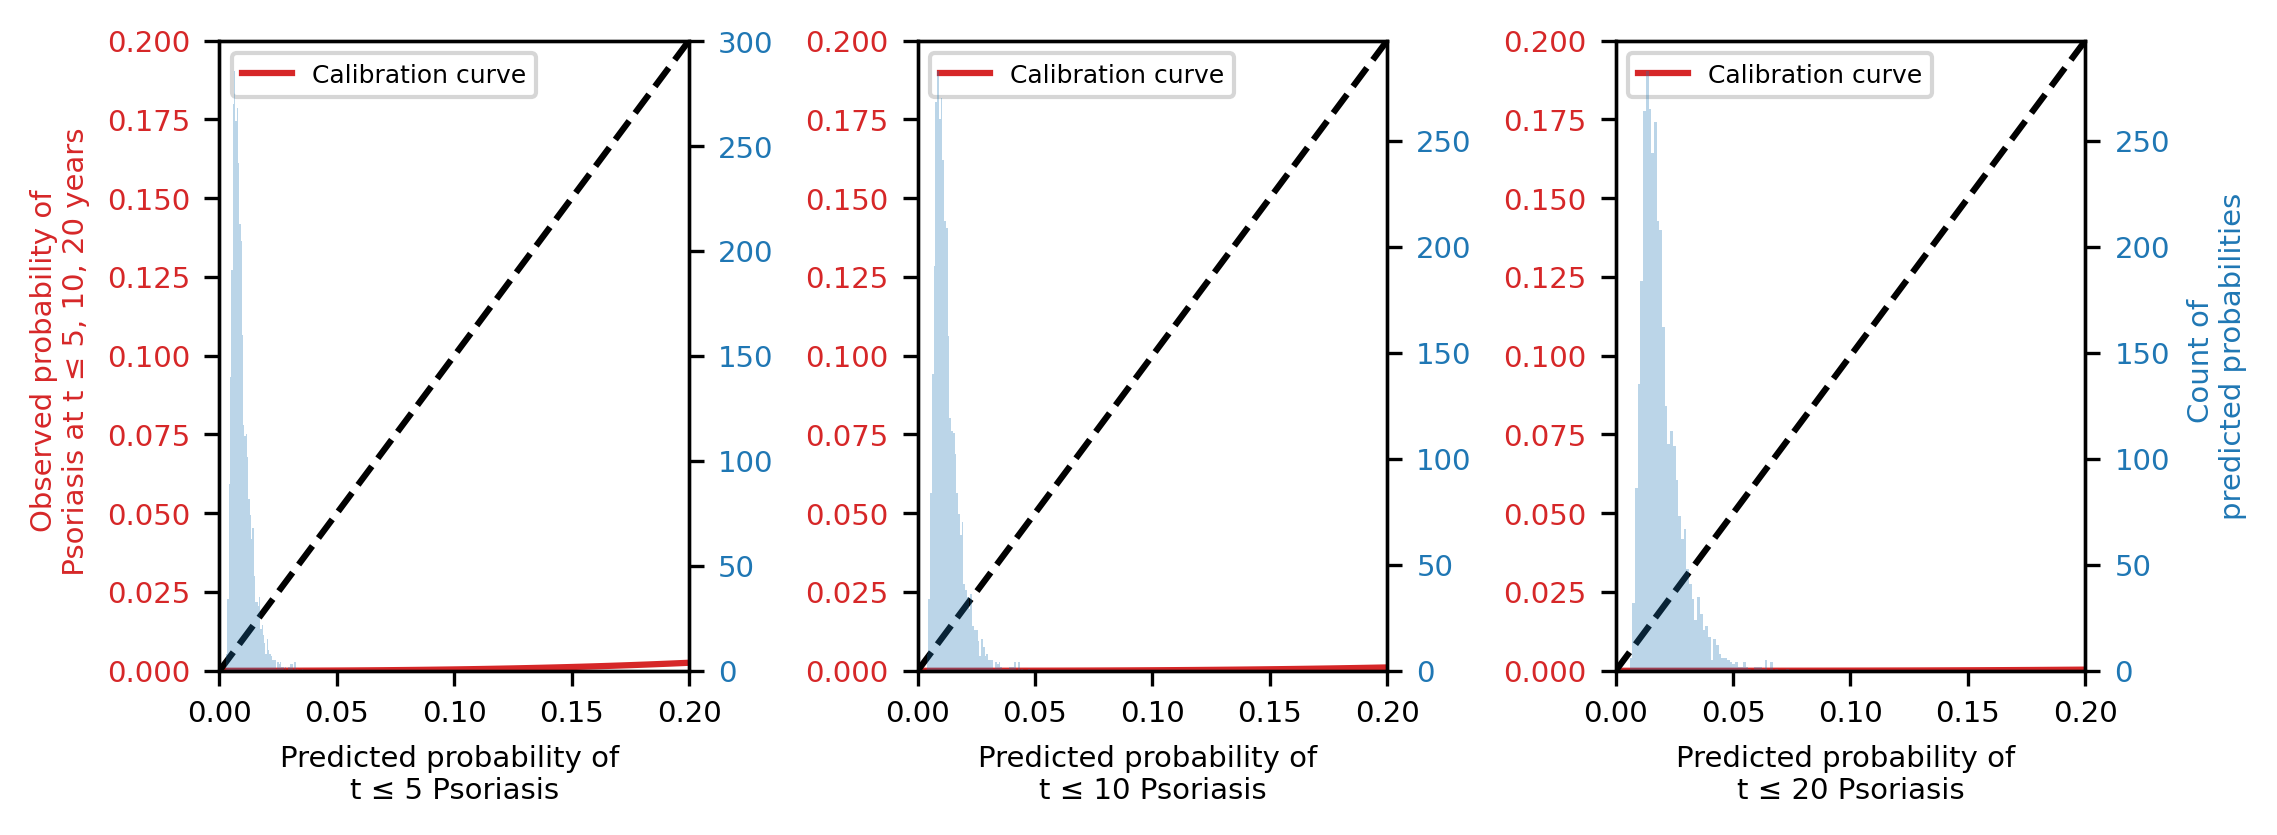

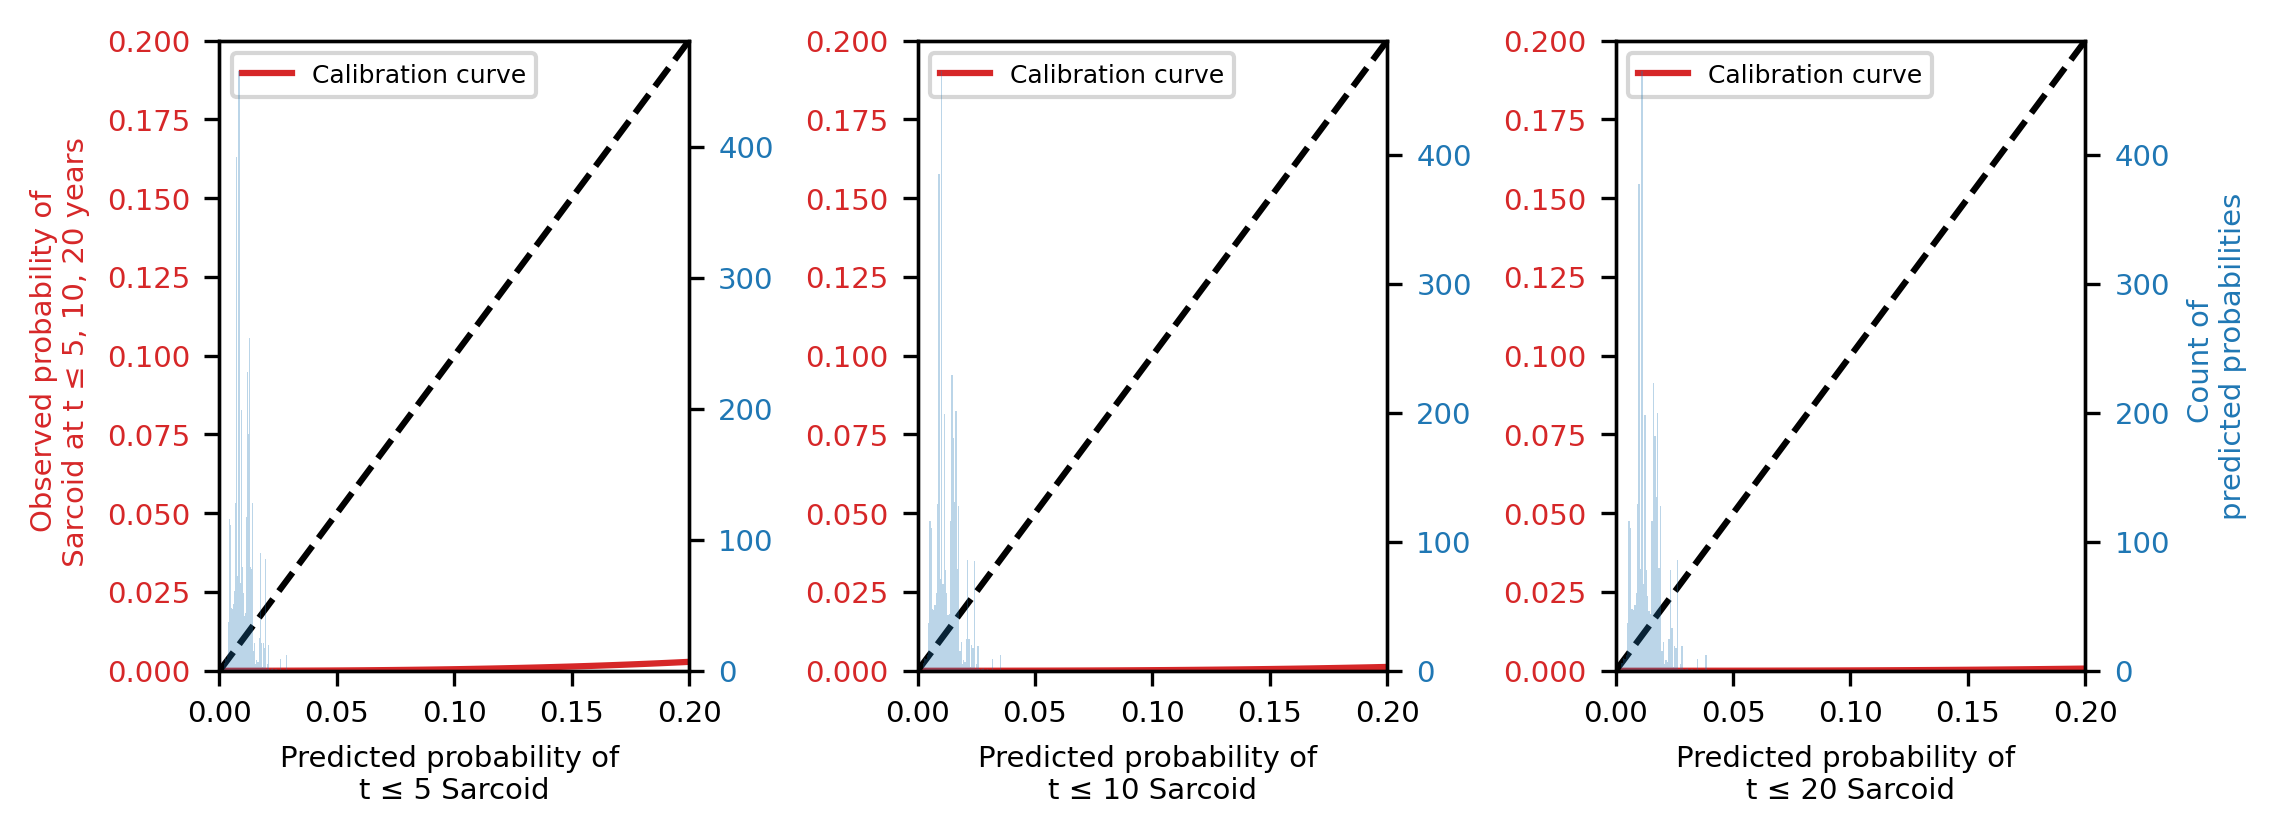

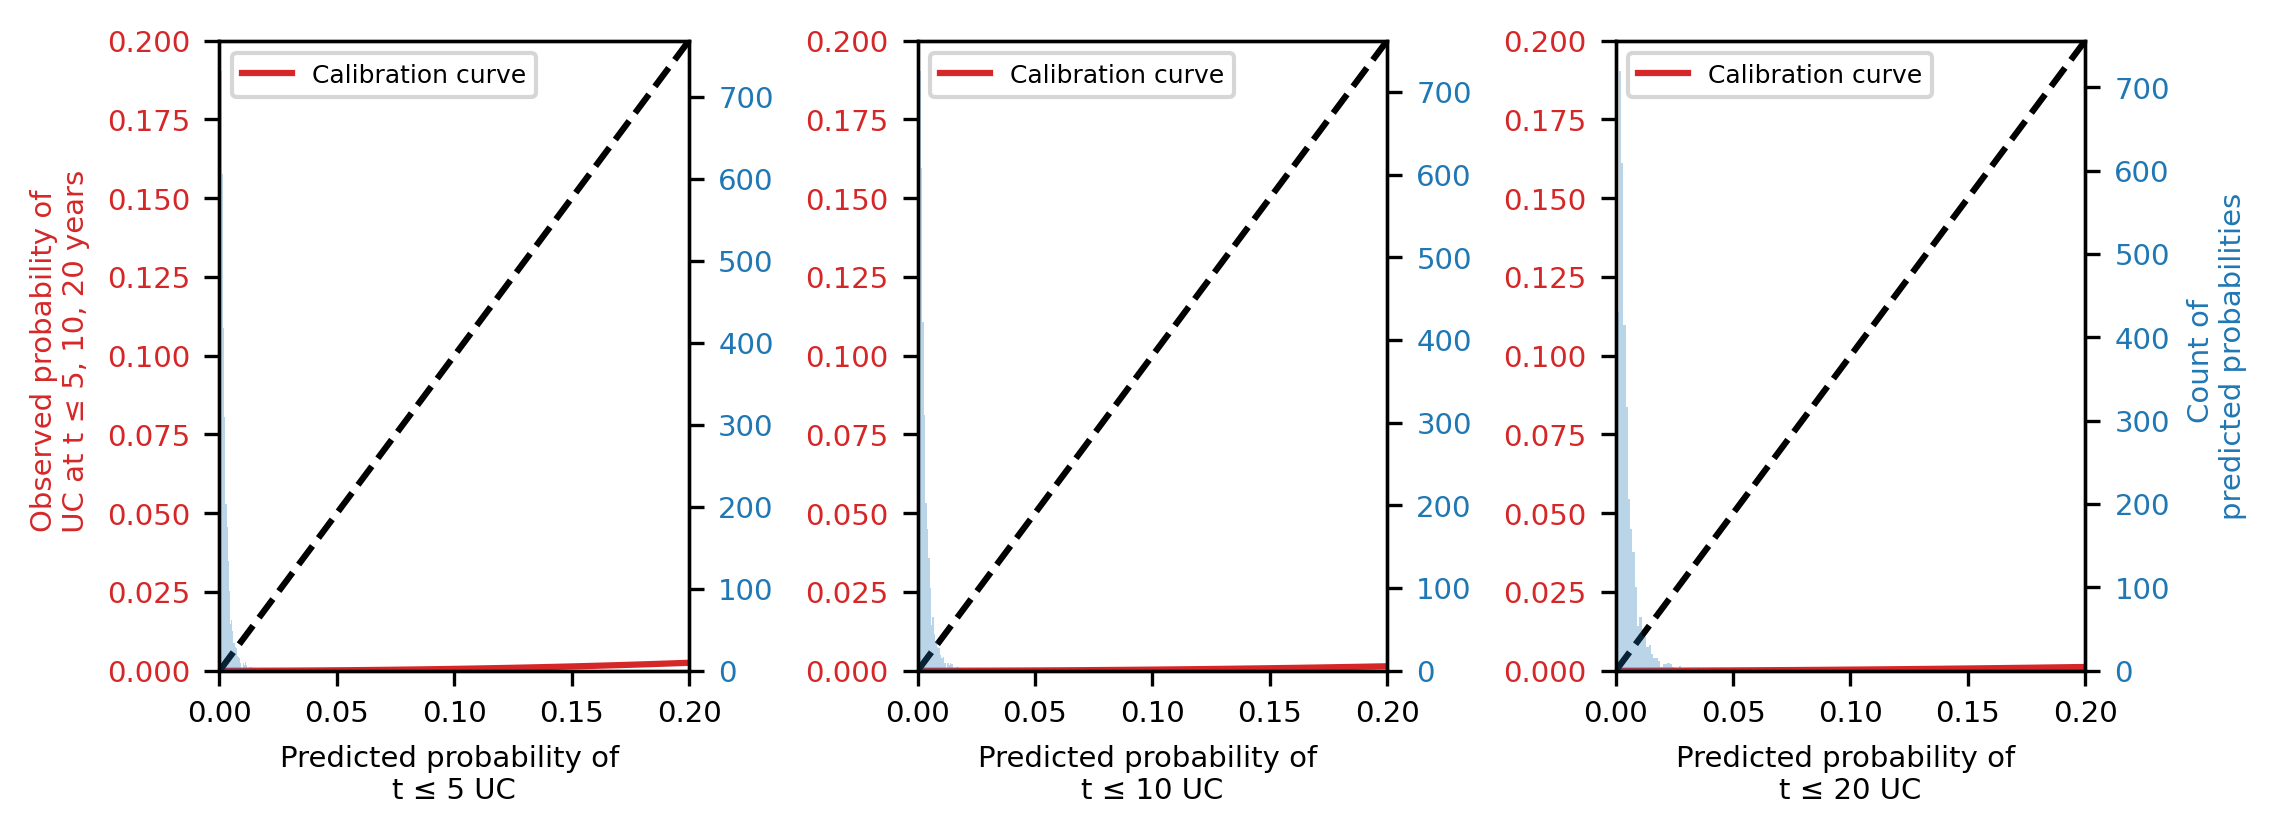

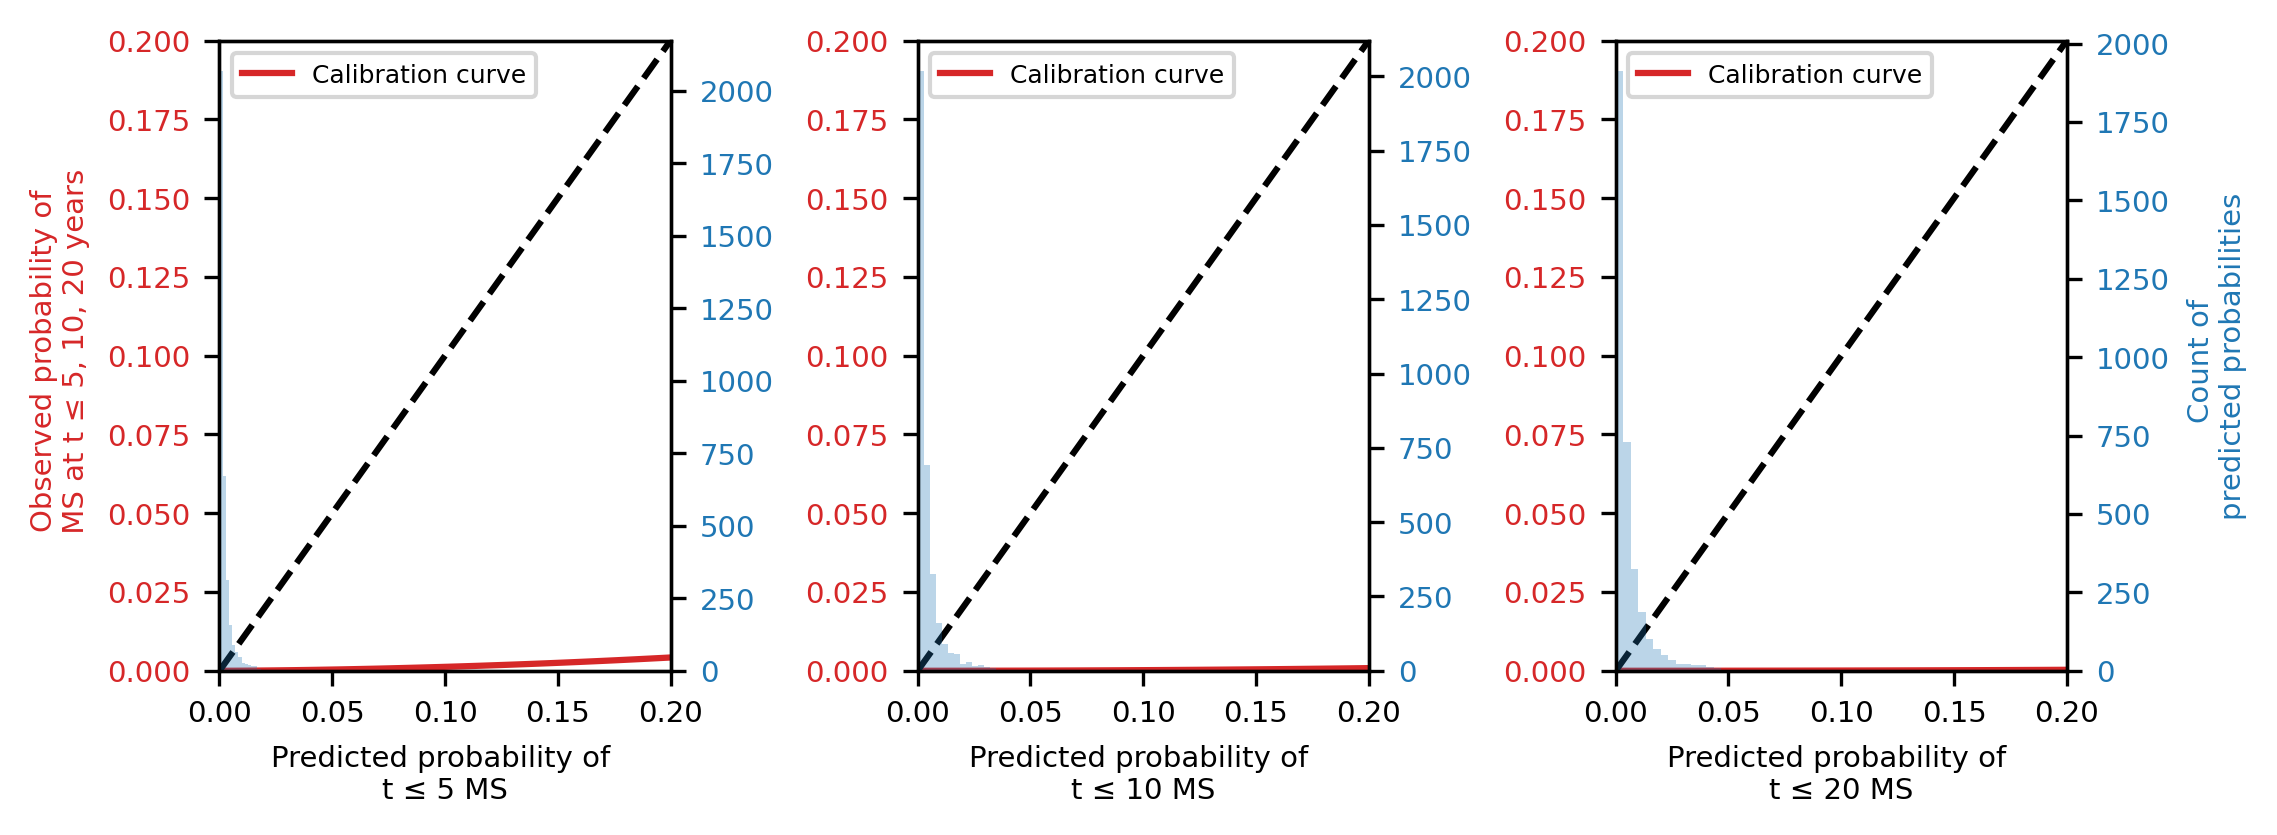

In [44]:
# Define font styles for ticks on axes
tick_font = {
    'family': 'sans-serif',  # Font family for the tick labels
    'weight': 'medium',  # Font weight for the tick labels (e.g., 'medium')
    'size': 7,  # Font size for the tick labels
}

# Define font styles for labels
label_font = {
    'family': 'sans-serif',  # Font family for the label text
    'weight': 'medium',  # Font weight for the label text (e.g., 'medium')
    'size': 10,  # Font size for the label text
}

# Set the font style for tick labels using the defined 'tick_font'
plt.rc('font', **tick_font)

# Define the width of a figure with double-column layout (for publishing requirements)
double_col_width = 7.0867

# Define the width of a figure with single-column layout (for publishing requirements)
col_width = 3.46457
# Subplot 1: Survival Probability Calibration at t0 = 5 years

n_knots =  [3,3,3,3,3,3,3]
for i, (model, df, nk) in enumerate(zip(models, dfs, n_knots)):
    cph = model
    cph_data = df
    event = model.event_col.lstrip('first_uve_')
    
    plt.figure(figsize=[7.6, 5], dpi=300, facecolor=None)
    plt.subplot(234)

    ax = survival_probability_calibration(model=cph, df=cph_data, t0=5,
                                          left_y_axis=True, event=event, n_knots=nk)[0]

    # Subplot 2: Survival Probability Calibration at t0 = 10 years
    plt.subplot(235)
    ax = survival_probability_calibration(model=cph, df=cph_data, t0=10, event=event, n_knots=nk)[0]


    # Subplot 3: Survival Probability Calibration at t0 = 20 years
    plt.subplot(236)
    ax= survival_probability_calibration(model=cph, df=cph_data, t0=20, right_y_axis=True, event=event, n_knots=nk)[0]

plt.tight_layout()
plt.savefig('calibration_curves_170824.svg')

In [39]:
importlib.reload(survival_analysis.stratifiedKM_plot)
from  survival_analysis.stratifiedKM_plot import *

## Consolidating and BH procedure

In [36]:
def consolidate_model_data(models, model_names):
    # Initialize a list to store data
    data = []

    for model, name in zip(models, model_names):
        # Extract data from the summary DataFrame of each model
        summary = model.summary
        variables = summary.index
        p_values = summary['p']
        hazard_ratios = summary['exp(coef)']
        lower_cis = summary['exp(coef) lower 95%']
        upper_cis = summary['exp(coef) upper 95%']

        # Append model name, variable name, hazard ratio, confidence intervals, and p-value to the data list
        for variable, p_value, hazard_ratio, lower_ci, upper_ci in zip(variables, p_values, hazard_ratios, lower_cis, upper_cis):
            data.append({
                'Model': name,
                'Variable': variable,
                'Hazard Ratio': hazard_ratio,
                'Lower CI': lower_ci,
                'Upper CI': upper_ci,
                'P-Value': p_value
            })

    # Create a DataFrame from the list
    consolidated_df = pd.DataFrame(data)

    return consolidated_df

def benjamini_hochberg_correction(df, alpha_significant=0.05, alpha_suggestive=0.1):
    p_values = df['P-Value'].values
    sorted_indices = np.argsort(p_values)
    sorted_p_values = p_values[sorted_indices]
    m = len(p_values)

    # Calculate adjusted p-values for BH correction
    adjusted_p_values = np.zeros(m)
    adjusted_p_values[sorted_indices] = (sorted_p_values * m) / (np.arange(1, m + 1))

    # Threshold for significant findings
    significant = adjusted_p_values <= alpha_significant
    # Threshold for suggestive findings
    suggestive = (adjusted_p_values <= alpha_suggestive) & ~significant

    # Add new columns to the original DataFrame
    df['Adjusted_P_Value'] = adjusted_p_values
    df['Significant_BH'] = significant
    df['Suggestive_BH'] = suggestive

    return df



In [37]:
model_names = [
    'Ankylosing Spondylitis',  # cph_as refers to Ankylosing Spondylitis
    "Crohn's Disease",        # cph_crohns refers to Crohn's Disease
    'Multiple Sclerosis',      # cph_ms refers to Multiple Sclerosis
    'Psoriasis',               # cph_psoriasis refers to Psoriasis
    'Rheumatoid Arthritis',    # cph_ra refers to Rheumatoid Arthritis
    'Ulcerative Colitis',      # cph_uc refers to Ulcerative Colitis
    'Sarcoidosis'              # cph_sarcoid refers to Sarcoidosis
]

# Defining models
models = [cph_as, cph_crohns, cph_ms, cph_psoriasis, cph_ra, cph_uc, cph_sarcoid]

corrected_df = benjamini_hochberg_correction(
    consolidate_model_data(models, model_names)
)


In [37]:
i=0
for model in models:
    # print(f"{model.concordance_index_:.2f}",
    #       f"{model.event_observed.sum()} out of {len(model.event_observed)}"
    #       +f" ({model.event_observed.sum()/len(model.event_observed)*100:.1f}%)")
    
    for var, row in model.summary.iterrows():

        print(var, "\n", '(', round(row['exp(coef)'], 2), ", ",
              round(row['exp(coef) lower 95%'], 2), '-', round(row['exp(coef) upper 95%'],2),
              ", p=", round(corrected_df.loc[i, 'Adjusted_P_Value'], 4),")", sep="")
        i+=1
    print("\n")

AS_GRS
(1.75, 1.53-2.0, p=0.0)
age_uve_binary
(2.15, 1.29-3.57, p=0.0124)
Sex_Female
(0.66, 0.43-1.03, p=0.1024)


age_uve_binary
(2.13, 1.04-4.36, p=0.0658)
Sex_Female
(1.53, 0.82-2.84, p=0.2244)


MS_GRS
(2.4, 1.63-3.51, p=0.0001)
age_uve_binary
(4.07, 1.35-12.21, p=0.0374)
Sex_Female
(2.6, 1.08-6.28, p=0.0619)


Psoriasis_GRS
(1.31, 1.05-1.63, p=0.0349)
TDI
(1.08, 1.01-1.16, p=0.0395)
age_uve_years
(1.0, 0.98-1.02, p=0.8516)
Sex_Female
(0.72, 0.46-1.13, p=0.2075)


RhA_GRS
(1.48, 1.17-1.87, p=0.0056)
BMI
(1.08, 1.04-1.13, p=0.0004)
ever_smoked_yes
(1.65, 1.0-2.73, p=0.0791)
AS_GRS
(1.33, 1.13-1.56, p=0.0028)
age_uve_years
(1.01, 0.99-1.04, p=0.2461)
Sex_Female
(1.04, 0.64-1.71, p=0.8714)


IBD_GRS
(1.78, 1.18-2.68, p=0.0215)
age_uve_years
(0.96, 0.93-0.99, p=0.0386)
Sex_Female
(1.49, 0.63-3.56, p=0.418)


Sarcoid_GRS
(1.41, 1.04-1.91, p=0.0516)
age_uve_binary
(1.55, 0.86-2.8, p=0.2015)
Sex_Female
(1.11, 0.62-1.97, p=0.7904)




In [40]:
def create_forest_plot(df, model_names, figsize= (15, 12)):
    fig, ax = plt.subplots(figsize=figsize, dpi=200)
    y_offset = 0

    for i, model_name in enumerate(model_names):

        # Filter data for each model
        model_data = df[df['Model'] == model_name]
        hazards = model_data['Hazard Ratio']
        lower_ci = list(model_data['Lower CI'])
        upper_ci = list(model_data['Upper CI'])
        p_values = model_data['Adjusted_P_Value']
        
        
        y_positions = range(len(hazards))
        y_positions = [y + y_offset for y in y_positions]
        
        # Different markers based on adjusted p-value
        markers = ['x' if p < 0.05 else 'v' if p < 0.1 else 'o' for p in p_values]
        sizes = [170 if p < 0.05 else 110 if p < 0.1 else 70 for p in p_values]
        
        
        for j, (haz, pos, marker, size) in enumerate(zip(hazards, y_positions, markers, sizes)):

            variable_name = model_data.iloc[j]['Variable']
            colour = ('orangered' if 'GRS' in variable_name
                      else 'forestgreen' if 'age' in variable_name
                      else 'gray')
            ax.scatter(haz, pos, s=size, zorder=3, marker=marker, color=colour)
            ax.hlines(pos, lower_ci[j], upper_ci[j], colors='black', lw=2, zorder=2, alpha=0.8)
            
            # Display variable name, hazard ratio, and p-value
            ax.text(-0.01, pos, f"{format_label(variable_name)} ({haz:.1f})", va='center', ha='right')
            t = ax.text(0.1, pos, f"P{format_p_value(p_values.iloc[j])}",
                        va='center', ha='left', fontsize=10)
            t.set_bbox(dict(facecolor='w', alpha=0.7, edgecolor='w'))
        
        ax.text(-0.05, y_offset +len(hazards), model_name, fontsize=11,ha='right',weight='bold')
        
        # Add dashed line between models
        if i < len(model_names) - 1:
            ax.axhline(y_offset + len(hazards) + 1, color='gray', linestyle='--', alpha=0.4)
        
        y_offset += len(hazards) +2

    ax.set_yticks([])
    ax.set_xlim(0, 5.5)
    
    ax.axvline(1, color='red', linestyle='--', zorder=1, alpha=0.7)
    ax.set_xlabel('Hazard Ratio (95% CI)')
    
    ax.set_title('Forest Plot of Cox Proportional Hazards Models')
    
    # Add legend for markers
    ax.scatter([], [], marker='x', label='P < 0.05', color='black')
    ax.scatter([], [], marker='v', label='0.05 ≤ P< 0.1', color='black')
    ax.scatter([], [], marker='o', label='P ≥ 0.1', color='black')
    ax.legend(title='Significance,\nBH-corrected P-val', loc='upper center', bbox_to_anchor=(0.9, 0.99))
    
    return fig



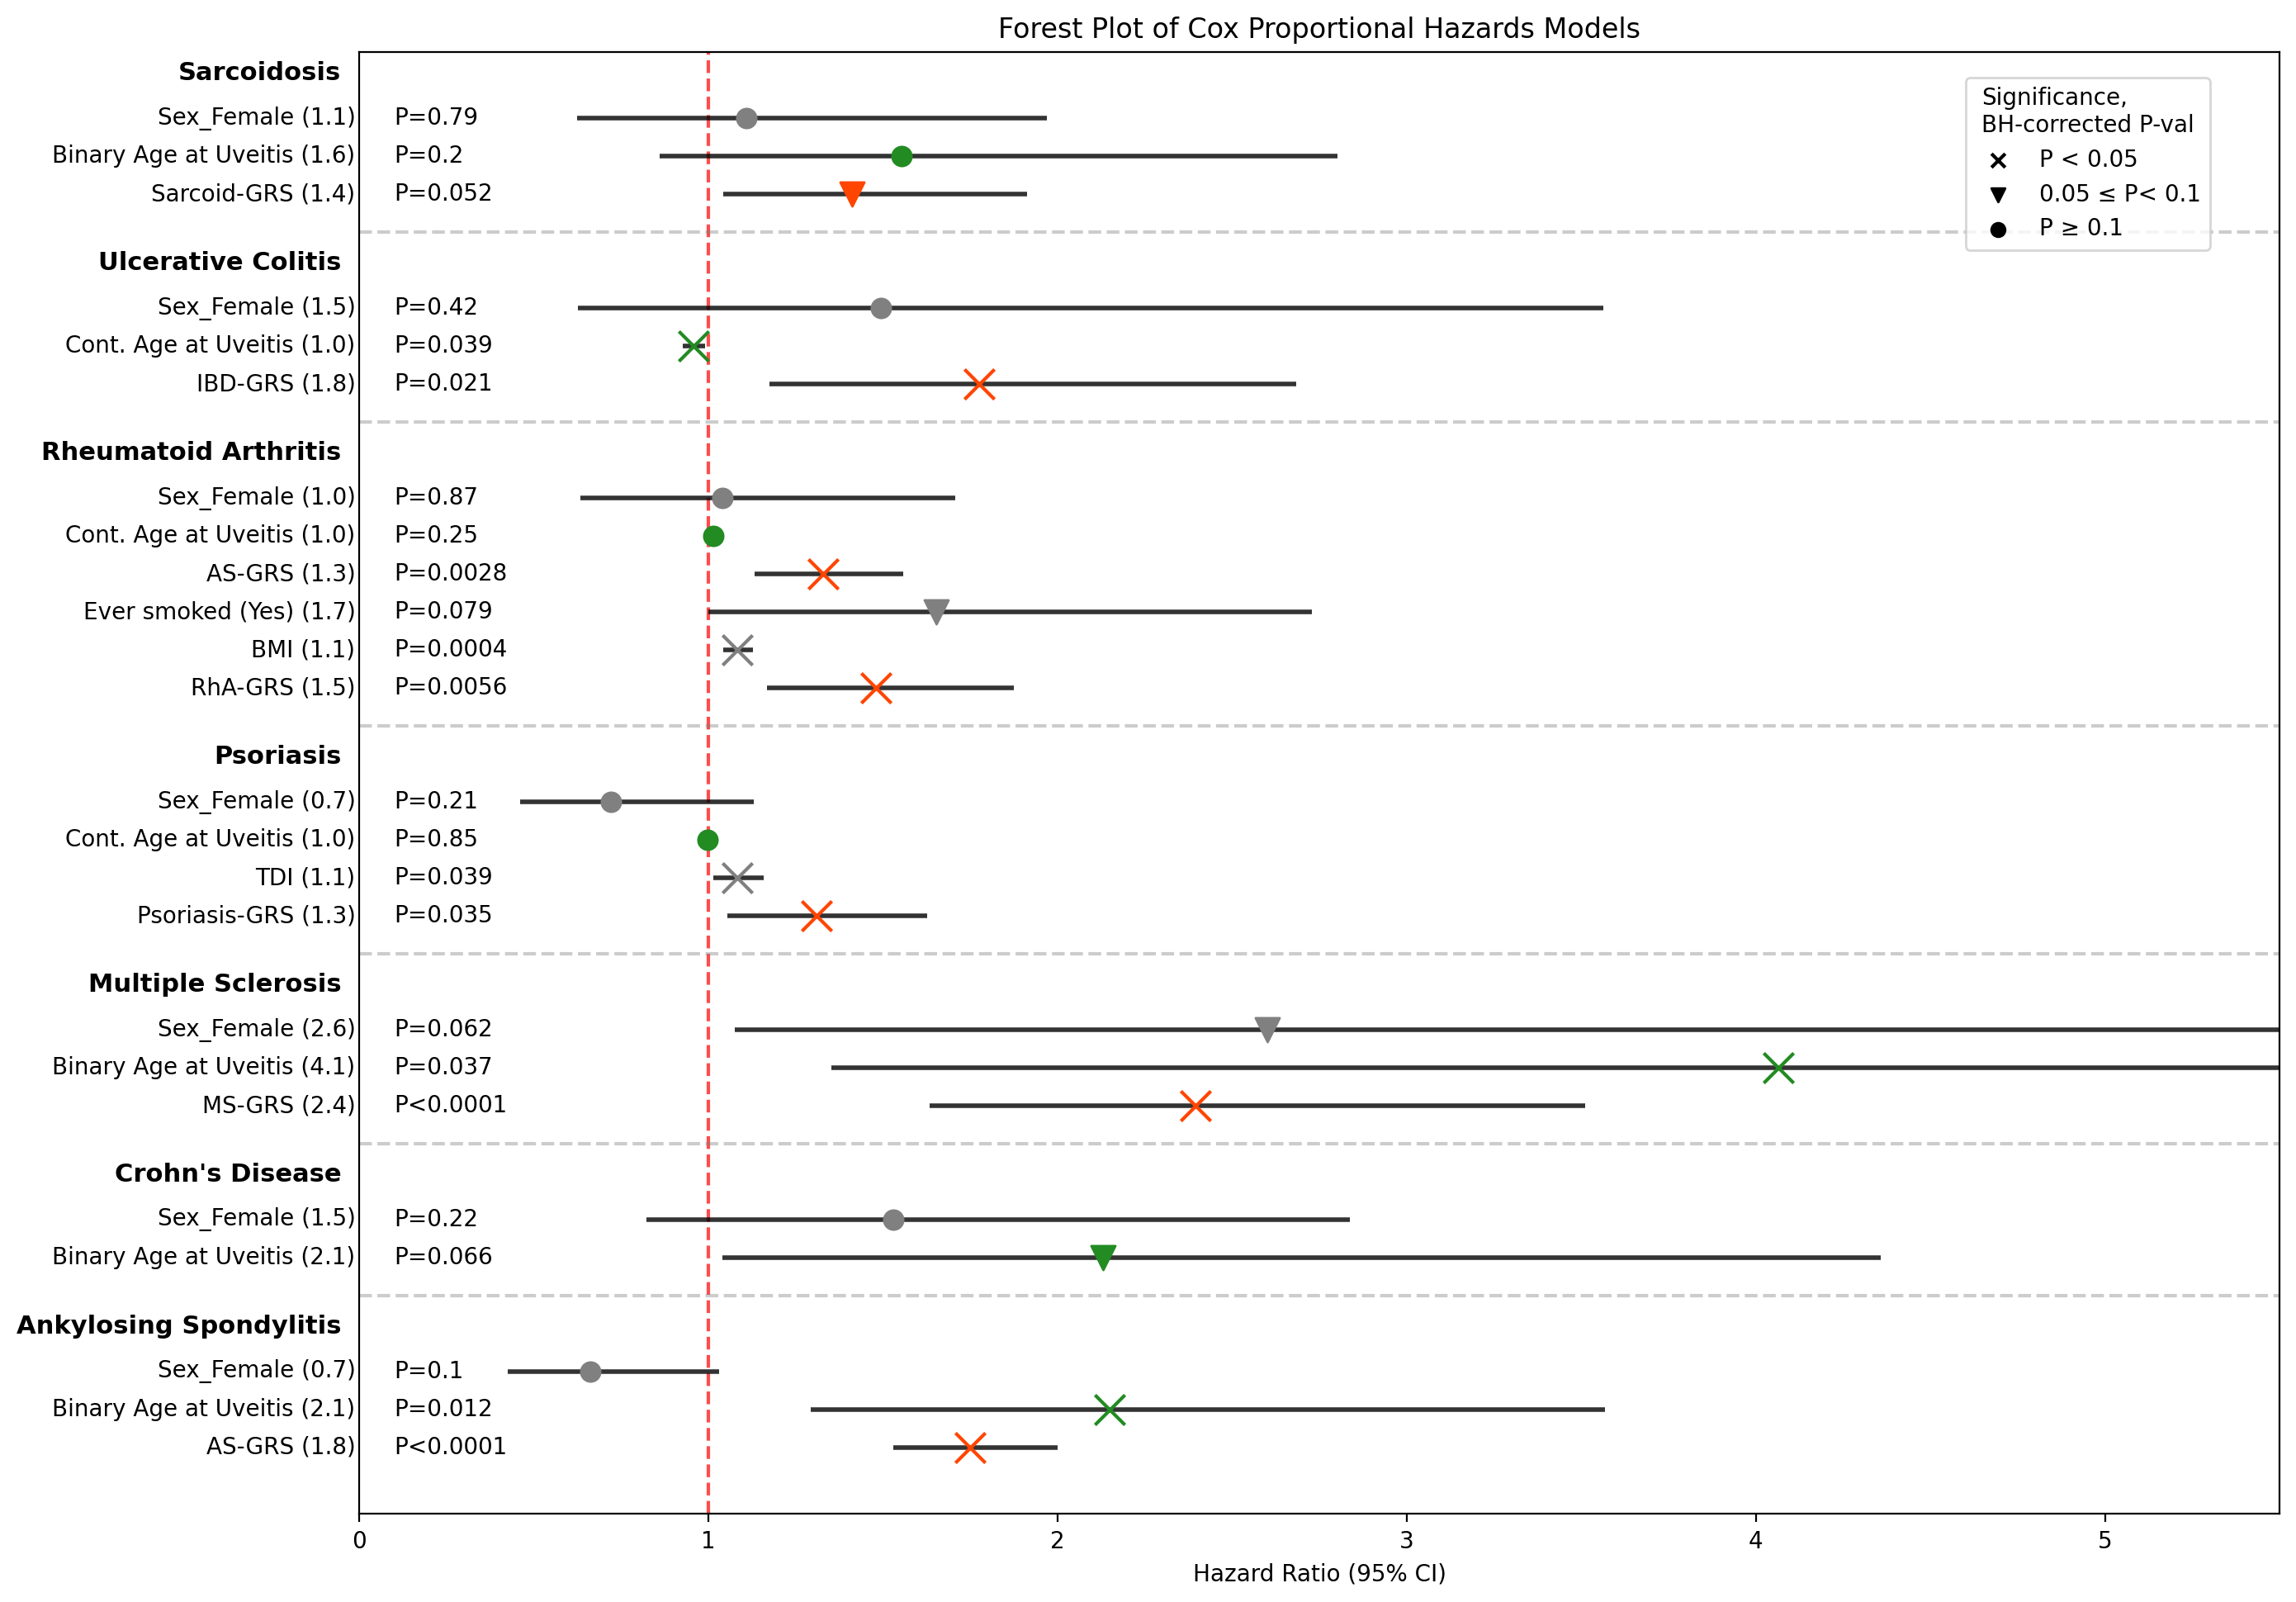

In [41]:
def format_label(label):
    formatted_label = ('Sex' if 'sex' in label
                       else 'Binary Age at Uveitis' if 'uve_bin' in label
                       else '-'.join(label.split('_')) if 'grs' in label.lower()
                       else 'Ever smoked (Yes)' if 'smok' in label.lower()
                       else 'Cont. Age at Uveitis' if 'age_uve_years' in label.lower()
                       else label)
                      

    return formatted_label

# Create and display the plot
fig = create_forest_plot(corrected_df, model_names, figsize=(14, 14*0.7))
plt.tight_layout()
plt.savefig('cph_summaries/allmodels_forest_060824.svg')
plt.show()

<AxesSubplot:xlabel='HR (95% CI)'>

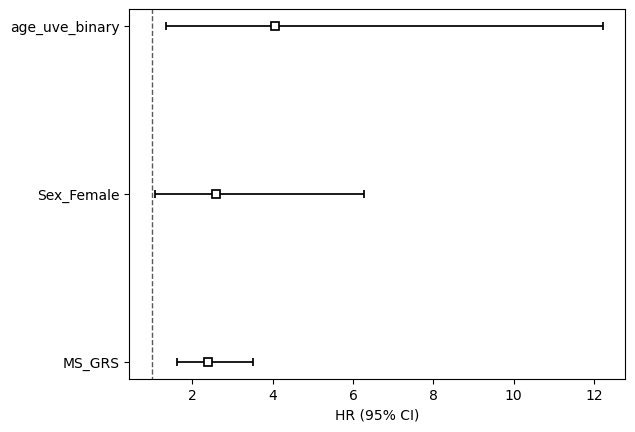

In [83]:
cph_ms.plot(hazard_ratios=True)

In [ ]:
cph_data['cph_prediction'] = cph.predict_partial_hazard(cph_data)
plot_km(cph_data, cut_off_dict=cut_off_tertiles,event='first_uve_Psoriasis',ylim=[.90,1],
        xlim=[0,45], time='uve_to_Psoriasis_years',
        save_label='Psoriasis_Uveitis_KM_22ndJuly24', plot_label = '', figsize=[col_width,col_width])
